Using multiple DL architectures for classifying imdb reviews into positive and negative

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="../data/", download=False)


# Get the train and test sets
train_dataset, test_dataset = imdb['train'], imdb['test']

In [29]:
# Building vocabulary based on training dataset

VOCAB_SIZE = 10000
MAX_LENGTH = 120
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'


# Instantiate the vectorization layer
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, ragged=True)

# Get the string inputs and integer outputs of the training set
train_reviews = train_dataset.map(lambda review, label: review)

# Generate the vocabulary based only on the training set
vectorize_layer.adapt(train_reviews)

# Delete because it's no longer needed
del train_reviews

In [33]:
def preprocessing_function(dataset):
    # Applying vectorization to the string data
    dataset_seq = dataset.map(lambda text, label : (vectorize_layer(text), label))
    
    # Putting all the elements in a single ragged batch
    dataset_seq = dataset_seq.ragged_batch(
                                          batch_size=dataset_seq.cardinality())
    
    
    # Output a tensor from the single batch. Extract the sequences and labels.
    sequences, labels = dataset_seq.get_single_element()
    
    
    # Pad the sequences
    padded_sequences = tf.keras.utils.pad_sequences(
        sequences.numpy(), maxlen=MAX_LENGTH, truncating=TRUNC_TYPE, padding=PADDING_TYPE
    )
    
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)
    labels = tf.data.Dataset.from_tensor_slices(labels)
    
    dataset_vectorize = tf.data.Dataset.zip(padded_sequences, labels)
    
    return dataset_vectorize

In [34]:
train_dataset_vectorized = preprocessing_function(train_dataset)
test_dataset_vectorized = preprocessing_function(test_dataset)

In [35]:
# View 2 training sequences and its labels
for example in train_dataset_vectorized.take(2):
  print(example)
  print()

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,   11,   14,   34,  412,  384,   18,   90,
         28,    1,    8,   33, 1322, 3560,   42,  487,    1,  191,   24,
         85,  152,   19,   11,  217,  316,   28,   65,  240,  214,    8,
        489,   54,   65,   85,  112,   96,   22, 5596,   11,   93,  642,
        743,   11,   18,    7,   34,  394, 9522,  170, 2464,  408,    2,
         88, 1216,  137,   66,  144,   51,    2,    1, 7558,   66,  245,
         65, 2870,   16,    1, 2860,    1,    1, 1426, 5050,    3,   40,
          1, 1579,   17, 3560,   14,  158,   19,    4, 1216,  891, 8040,
          8,    4,   18,   12,   14, 4059,    5,   99,  146, 1241,   10,
        237,  704,   12,   48,   24,   93,   39,   11, 7339,  152,   39,
       1322,    1,   50,  398,   10,   96, 1155,  851,  141,    9])>, <tf.Tensor: shape=(), dtype=int64, numpy=0>)

(<tf.Tensor: shape=(120,), dtype=int32, numpy=
array([   0,    0,    0,    0,    0,    0,    0,    0,   10,

In [36]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

# Optimize and batch the datasets for training
train_dataset_final = (train_dataset_vectorized
                       .cache()
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .prefetch(PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                       )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

Plot utility function

In [37]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

## Using Flatten layer after embed

In [38]:
# Parameters
EMBEDDING_DIM = 16
DENSE_DIM = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1920)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │          11,526 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,533 (670.05 KB)

 Trainable params: 171,533 (670.05 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
NUM_EPOCHS = 10

# Train the model
history_flatten = model_flatten.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6398 - loss: 0.6080 - val_accuracy: 0.8070 - val_loss: 0.4170
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8742 - loss: 0.2996 - val_accuracy: 0.8176 - val_loss: 0.4189
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9497 - loss: 0.1529 - val_accuracy: 0.8044 - val_loss: 0.5218
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9907 - loss: 0.0449 - val_accuracy: 0.8028 - val_loss: 0.6107
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9974 - loss: 0.0144 - val_accuracy: 0.8054 - val_loss: 0.6830
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9990 - loss: 0.0060 - val_accuracy: 0.8021 - val_loss: 0.7584
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9998 - loss: 0.0020 - val_accuracy: 0.8022 - val_loss: 0.8168
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 1.0000 - loss: 6.9714e-04 - val_accuracy

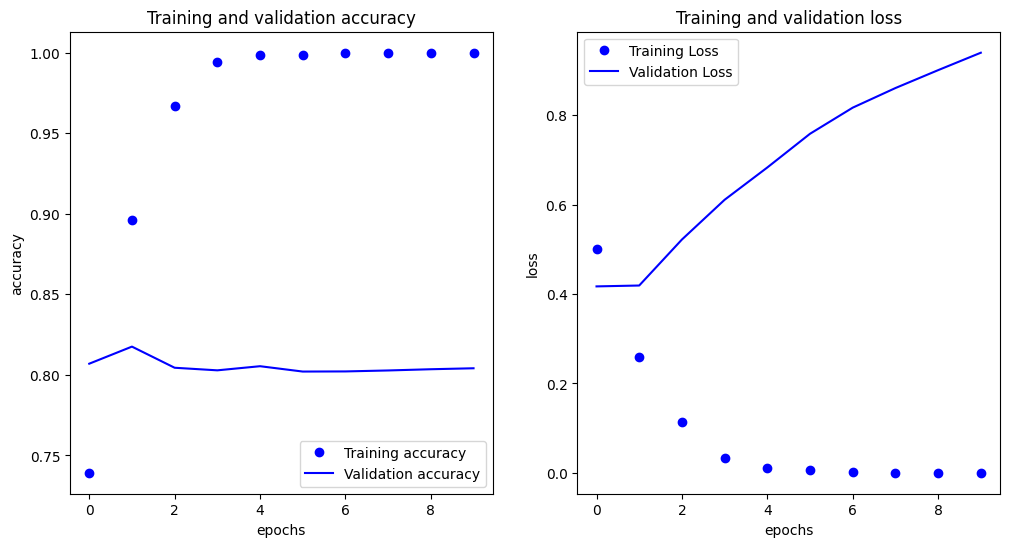

In [40]:
# Plot the accuracy and loss history
plot_loss_acc(history_flatten)

## Single LSTM Layer after Embed

In [41]:
# Parameters
EMBEDDING_DIM = 16
LSTM_DIM = 32
DENSE_DIM = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 172,941 (675.55 KB)

 Trainable params: 172,941 (675.55 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=test_dataset_final)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 60ms/step - accuracy: 0.6534 - loss: 0.5900 - val_accuracy: 0.8276 - val_loss: 0.3927
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.8653 - loss: 0.3240 - val_accuracy: 0.8208 - val_loss: 0.4302
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.9041 - loss: 0.2491 - val_accuracy: 0.8087 - val_loss: 0.4649
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9290 - loss: 0.1926 - val_accuracy: 0.8065 - val_loss: 0.5247
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9469 - loss: 0.1469 - val_accuracy: 0.8032 - val_loss: 0.5852
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.9644 - loss: 0.1065 - val_accuracy: 0.7897 - val_loss: 0.6756
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9731 - loss: 0.0815 - val_accuracy: 0.7897 - val_loss: 0.8334
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.9774 - loss: 0.0648 - 

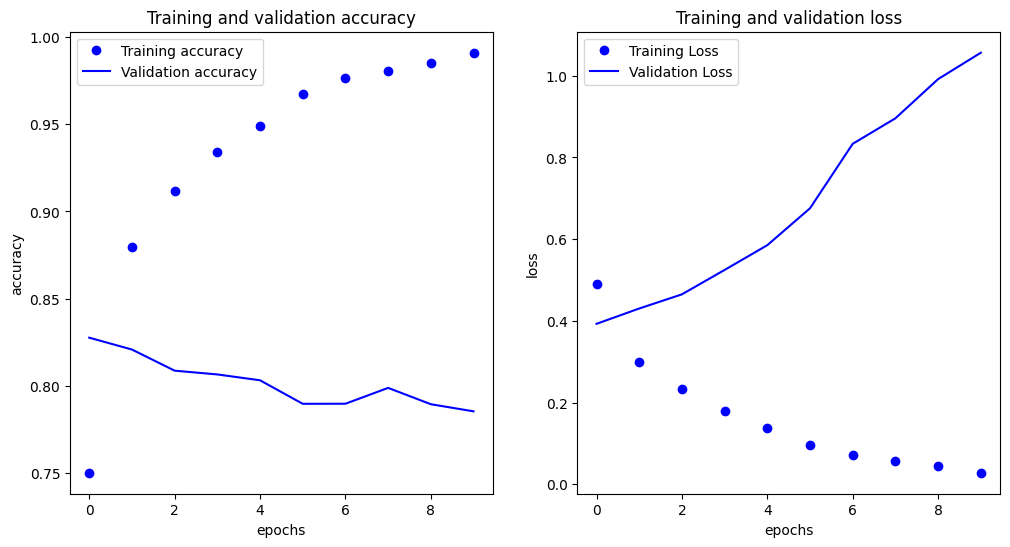

In [43]:
# Plot the accuracy and loss history
plot_loss_acc(history_lstm)

## GRU after embed

The *Gated Recurrent Unit* or [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU) is usually referred to as a simpler version of the LSTM. It can be used in applications where the sequence is important but you want faster results and can sacrifice some accuracy. You will notice in the model summary that it is a bit smaller than the LSTM and it also trains faster by a few seconds.

In [44]:
# Parameters
EMBEDDING_DIM = 16
GRU_DIM = 32
DENSE_DIM = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(GRU_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,997 (664.05 KB)

 Trainable params: 169,997 (664.05 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
NUM_EPOCHS = 10

# Train the model
history_gru = model_gru.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.6024 - loss: 0.6264 - val_accuracy: 0.8064 - val_loss: 0.4516
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 32ms/step - accuracy: 0.8540 - loss: 0.3409 - val_accuracy: 0.8121 - val_loss: 0.4203
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9024 - loss: 0.2475 - val_accuracy: 0.8135 - val_loss: 0.4501
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.9297 - loss: 0.1847 - val_accuracy: 0.8075 - val_loss: 0.5551
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.9517 - loss: 0.1335 - val_accuracy: 0.7917 - val_loss: 0.6366
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.9715 - loss: 0.0856 - val_accuracy: 0.7865 - val_loss: 0.7550
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.9819 - loss: 0.0569 - val_accuracy: 0.7924 - val_loss: 0.8766
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.9854 - loss: 0.0445 - 

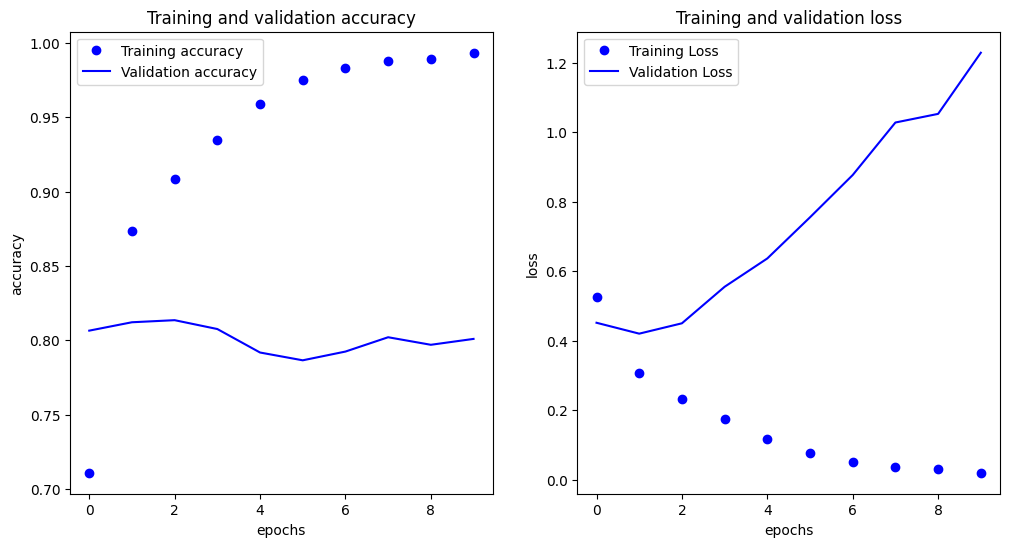

In [46]:
# Plot the accuracy and loss history
plot_loss_acc(history_gru)

## Convolution after embed

Lastly, you will use a convolution layer to extract features from your dataset. You will append a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer to reduce the results before passing it on to the dense layers. Like the model with `Flatten`, this also trains much faster than the ones using RNN layers like `LSTM` and `GRU`.

In [47]:
# Parameters
EMBEDDING_DIM = 16
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.Input(shape=(MAX_LENGTH,)),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    tf.keras.layers.Conv1D(FILTERS, KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 120, 16)             │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 116, 128)            │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             774 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,149 (668.55 KB)

 Trainable params: 171,149 (668.55 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
NUM_EPOCHS = 10

# Train the model
history_conv = model_conv.fit(train_dataset_final, epochs=NUM_EPOCHS, validation_data=(test_dataset_final))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7049 - loss: 0.5421 - val_accuracy: 0.8281 - val_loss: 0.3815
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8792 - loss: 0.2916 - val_accuracy: 0.8272 - val_loss: 0.3985
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9059 - loss: 0.2371 - val_accuracy: 0.8135 - val_loss: 0.4643
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9237 - loss: 0.1988 - val_accuracy: 0.8093 - val_loss: 0.4863
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9400 - loss: 0.1659 - val_accuracy: 0.7969 - val_loss: 0.5641
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9528 - loss: 0.1380 - val_accuracy: 0.8041 - val_loss: 0.6272
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9648 - loss: 0.1086 - val_accuracy: 0.8000 - val_loss: 0.7136
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9741 - loss: 0.0858 - val_accuracy: 0.

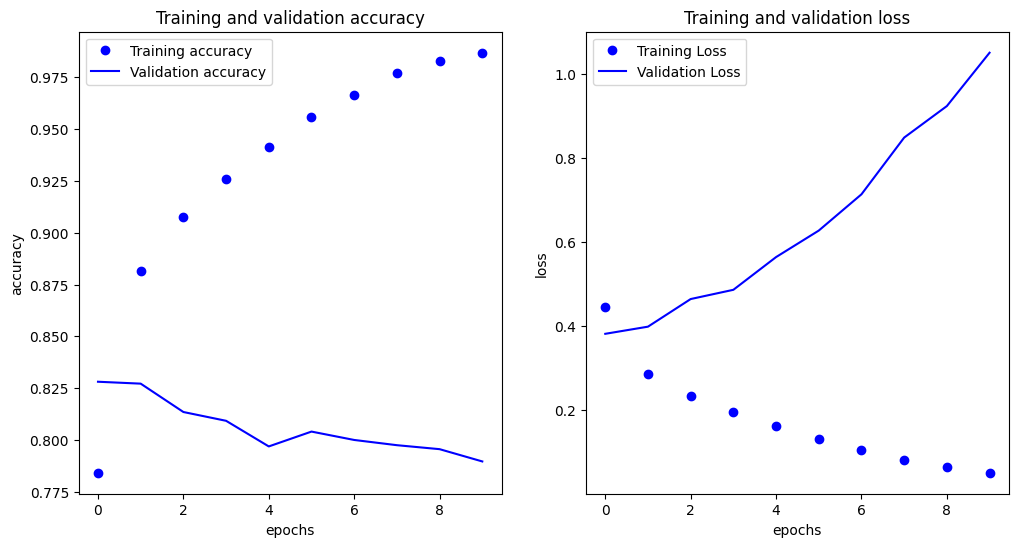

In [49]:
# Plot the accuracy and loss history
plot_loss_acc(history_conv)